# Check Motor Imagery Decoder
Use this clean notebook to check how the MI decoder is working... seems to always be guessing one direction.

Nile Wilson 2019.01.24

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt
from scipy.fftpack import fft, ifft
from scipy import signal
from mne.filter import filter_data

import scipy.signal as scisig
import numpy as np
import pandas as pd
import datetime
import pickle
import csv
import mne

## Function Definitions

In [2]:
def LoadEEGData(filename, EEGdevice):
    """ This function converts a single .easy file (from NIC2) to an easy-to-use dataframe.
    Uses both the .easy file and .info file (containing metadata)
    
    ---- Input ----
    filename: string containing the .easy filepath
    
    ---- Output ----
    df: dataframe containing all the EEG, accelerometer, and event marker data
    fs: sampling rate for the EEG data (Hz)
    fs_accel: sampling rate for the accelerometer data (Hz)
    
    """
    if EEGdevice == 7:
        x = 1
    elif EEGdevice == 8:
        # Read in the .easy file
        df = pd.read_csv(filename, delimiter='\t', header=None)

        # Get metadata from the .info file
        fname = filename[:-5] + '.info'
        with open(fname) as f:
            content = f.readlines()
        content = [x.strip() for x in content]

        # Get the channel names
        channel_info = [x for x in content if 'Channel ' in x]
        channel_names = []
        for ch in range(len(channel_info)):
            channel_names.append(channel_info[ch].split(': ')[1])

        channel_names.append('X')
        channel_names.append('Y')
        channel_names.append('Z')
        channel_names.append('STI 014')
        channel_names.append('DateTime')

        # Get sampling rates
        sampling_rates = [x for x in content if 'sampling rate: ' in x]
        fs_all = []
        for freq in range(len(sampling_rates)):
            tmp = sampling_rates[freq].split(': ')[1].split(' ')[0]
            if tmp in ['N/A']:
                print('Skipping N/A')
            else:
                fs_all.append(float(sampling_rates[freq].split(': ')[1].split(' ')[0]))

        # Store sampling rates
        fs = fs_all[0]
        fs_accel = fs_all[1]

        # Assign the column names
        df.columns = channel_names
    
    # Return dataframe and sampling rates
    return df, fs, fs_accel

In [3]:
def LoadBehavioralDataBCI(filename_behavioral):
    """
    This function loads behavioral data for the motor screening task and formats it to use in this script
    """
    behavioralData = pd.read_csv(filename_behavioral, ',')
    
    return behavioralData

In [4]:
def SyncTriggerPulsesBCI(EEGdata, EEGdevice, fs, behavioralData):
    """
    This function returns the indices for events of interest
    """
    
    if EEGdevice == 7:
        print('Put code here')
    elif EEGdevice == 8:
        # Store where the values in trigger are equal to 8 (the audio trigger input channel number)
        index_trigger = np.where(EEGdata['STI 014']!=0)
        index_trigger = index_trigger[0]

        # Number of trials is greater than number of total pulses sent
        # 999 when the task ends
        move_left_starts = np.where(EEGdata['STI 014'] == 1)[0]
        move_right_starts = np.where(EEGdata['STI 014'] == 2)[0]
        rest_starts = np.where(EEGdata['STI 014'] == 3)[0]
        rest_ends = np.where(EEGdata['STI 014'] == 4)[0]

        num_of_trials = len(rest_starts)
        num_of_movements = len(move_left_starts) + len(move_right_starts)
    
    return num_of_trials, num_of_movements, move_left_starts, move_right_starts, rest_starts, rest_ends

In [5]:
def EpochBCIData(EEGdata, move_left_starts, move_right_starts, rest_starts, rest_ends):
    """
    This function epochs the data
    """
    
    if EEGdevice == 7:
        channels = EEGdata.columns[1:8]
    elif EEGdevice == 8:
        channels = EEGdata.columns[0:7]

    epochs = []
    epochs_norm = []
    move_starts = np.sort(np.concatenate((move_left_starts,move_right_starts),0))

    for movement in range(0,len(move_starts)):
        # Data for this movement
        t_start = move_starts[movement] - np.round(1.00*fs)
        t_end = move_starts[movement] - np.round(0.250*fs)

        # Baseline
        restOfInt = np.max(np.where(rest_starts < move_starts[movement]))
        tb_start = rest_starts[restOfInt]
        tb_end = rest_ends[restOfInt]

        baseline = EEGdata.loc[tb_start:tb_end][channels]

        # Store epoch
        tmp = (EEGdata.loc[t_start:t_end][channels] - np.mean(baseline))/np.std(baseline)
        epochs_norm.append(tmp)
        epochs.append(EEGdata.loc[t_start:t_end][channels])

    return epochs, epochs_norm

In [6]:
def OrganizeTrials(behavioralData):
    """
    Organizes trials
    """
    
    # When target was to the left
    trialL = np.where(behavioralData['target_x'] < behavioralData['player_x'])
    
    # When target was to the right
    trialR = np.where(behavioralData['target_x'] > behavioralData['player_x'])
    
    # Create a single list that includes which trial is which (L = 0, R = 1)
    trial_type = np.zeros([1,len(behavioralData['score'])])
    trial_type[0][trialL] = 0
    trial_type[0][trialR] = 1

    trial_type = np.round(trial_type[0])

    return trial_type, trialL, trialR

In [15]:
def ExtractFeaturesBCI(epochs, num_of_movements, channelsToUse, ds_factor):
    """
    Extract signal features of interest
    """
    
    # Get the summed delta power for each trial
    alpha_power = dict.fromkeys(channelsToUse)
    beta_power = dict.fromkeys(channelsToUse)
    ds_f = ds_factor # downsampling factor

    for chanOfInt in channelsToUse:
        tmp_alpha = list()
        tmp_beta = list()

        for movement in range(0, num_of_movements):
            f, Pxx_den = signal.welch(signal.decimate(epochs[movement][chanOfInt],ds_f), fs/ds_f, scaling='spectrum')
            alpha_idx = np.where(np.logical_and(np.round(f) > 8, np.round(f) <= 12))
            tmp_alpha.append(np.sum(Pxx_den[alpha_idx]))

            beta_idx = np.where(np.logical_and(np.round(f) > 13, np.round(f) <= 30))
            tmp_beta.append(np.sum(Pxx_den[beta_idx]))

        alpha_power[chanOfInt] = tmp_alpha
        beta_power[chanOfInt] = tmp_beta
    
    return alpha_power, beta_power

In [8]:
def TrainDecoder(X, y):
    """
    Trains the decoder on ALL the data (does not split into test and train because this is all train)
    """
    # preprocess dataset, split into training and test part
    args = np.arange(len(X))
    np.random.shuffle(args)
    X = [X[i] for i in args]
    y = [y[i] for i in args]
    X = StandardScaler().fit_transform(X)
    

    # Determine model parameters
    activations = ['relu','tanh']
    alphas = np.logspace(-6, 3, 10)
    solvers = ['lbfgs','sgd']
    hyper_params = {"activation":activations, "alpha":alphas, "solver":solvers}
    grid = GridSearchCV(MLPClassifier(learning_rate='constant', random_state=1), param_grid=hyper_params, cv=KFold(n_splits=5), verbose=True)
    grid.fit(X, y)

    # Fit the model
    clf = grid.best_estimator_
    clf.fit(X,y)
    
    """
    # Split into train and test for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    grid.fit(X_train, y_train)

    # Fit the model
    clf = grid.best_estimator_
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    print(grid.best_estimator_)
    print('-----------')
    print('score: ' + str(score))
    print(confusion_matrix(y_test, clf.predict(X_test)))
    print('-----------')
    """
    
    return clf, X, y

## Variables to Set

In [9]:
subjID = 'nile'
EEGdevice = 8 # 7 for DSI-7, 8 for Enobio
filename_eeg = '../data/Enobio/20190125144918_Nile_BCI.easy'
filename_behavioral = '../data/Enobio/BCI_nile_R36.csv'

## Code to Run

### Run automatically

In [16]:
# Load EEG data
EEGdata, fs, fs_accel = LoadEEGData(filename_eeg, EEGdevice)

# Load behavioral data
behavioralData = LoadBehavioralDataBCI(filename_behavioral)

# Sync up trigger pulses
num_of_trials, num_of_movements, move_left_starts, move_right_starts, rest_starts, rest_ends = SyncTriggerPulsesBCI(EEGdata, EEGdevice, fs, behavioralData)

# Clean the data
EEGdata_orig = EEGdata.copy()
lf = 1
hf = 40

if EEGdevice == 7:
    channels = EEGdata.columns[1:8]
elif EEGdevice == 8:
    channels = EEGdata.columns[0:7]

# Format our data into an mne-friendly format
ch_types = ['eeg']*len(channels)
info = mne.create_info(ch_names=list(channels), sfreq=fs, ch_types=ch_types)
rawData = EEGdata[channels].values
rawData = np.transpose(rawData)
raw = mne.io.array.RawArray(rawData, info)
raw.set_montage(mne.channels.read_montage(kind='standard_1020'))
raw.filter(l_freq=lf, h_freq=hf)

# Make a copy of the original data just in case
EEGdata[channels] = raw.get_data().T

# Epoch the data
epochs, epochs_norm = EpochBCIData(EEGdata, move_left_starts, move_right_starts, rest_starts, rest_ends)

# Organize trial types
trial_type, trialL, trialR = OrganizeTrials(behavioralData)

# Get signal features
alpha_power, beta_power = ExtractFeaturesBCI(epochs_norm, num_of_movements, ['C3','C4'], 1)
motor_features = [alpha_power['C3'], alpha_power['C4'], beta_power['C3'], beta_power['C4']]
motor_features = np.transpose(motor_features)

Skipping N/A
Creating RawArray with float64 data, n_channels=7, n_times=36504
    Range : 0 ... 36503 =      0.000 ...    73.006 secs
Ready.
Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 1651 samples (3.302 sec) selected


## Test the BCI data with the loaded MI classifier
This is the Motor Imagery classifier that was created using the Motor Screening data, and was used while the BCI was online

In [17]:
# Load latest model and its associated data
model_file = '../data/Enobio/nile_MI_classifier_2019-01-25-12-58-00.sav' # load the most recent model
loaded_model = pickle.load(open(model_file, 'rb'))

models_data = '../data/Enobio/nile_data_for_MI_classifier_2019-01-25-12-58-00.npz' # load the most recent model
loaded_data = np.load(models_data)
X_loaded = loaded_data['X']
y_loaded = loaded_data['y']

In [24]:
# Scale the BCI motor features prior to classification
# (this is done online as well)
X = StandardScaler().fit_transform(motor_features)

In [27]:
# Look at the motor features in the BCI
print('A single example (one movement)')
print('BCI features: ' + str(motor_features[0]))
print('BCI features (scaled): ' + str(X[0]))

A single example (one movement)
BCI features: [0.0854196  0.01179012 0.4530293  0.04262396]
BCI features (scaled): [-0.35032311 -0.19251599  0.67060625 -0.04637718]


Okay, so this actually looks fine in this notebook... The values of the BCI features are similar to that of the features used in training the classifier.

However, when I'm running the task online, it only ever classifies the epochs as indicating right motor imagery and thus always move the cursor to the right.

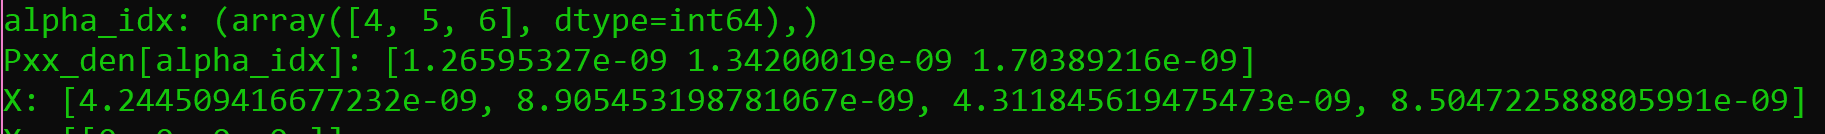

For example, looking at the above screenshot, we see that the values for our features, X, are really low. Instead of what we see here in this notebook around 0.08, 0.01, 0.45 etc, we see values in 4e-09.

In [28]:
# Look at the motor features used in training the decoder
print('A single example used for training (not in BCI)')
print('MI training features: ' + str(X_loaded[0]))

A single example used for training (not in BCI)
MI training features: [ 0.41480967 -0.14220343 -0.5599812   0.04194751]


In [18]:
# Test BCI data against loaded MI classifier
clf = loaded_model
clf.predict(motor_features)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1])

In [33]:
print('Score: ' + str(clf.score(X, trial_type)))
print(confusion_matrix(trial_type, clf.predict(X)))

Score: 0.46808510638297873
[[18 17]
 [ 8  4]]
